# T5 Model

The Multilingual Text Summarization Service is a service that aims to address the challenge of efficiently summarizing and translating textual information. Text summarization plays a crucial role in managing the massive amounts of information generated every day. This happens specifically in fields like news, research, or even social media. Traditional methods for summarizing text often struggle to manage the huge amounts and complexity of data; thus, this service bridges the gap between languages and the information overload that is produced every day.
<br><br>
The logic behind this service is a two-step process:

Summarization: Using a pre-trained T5 (Text-to-Text Transfer Transformer) model, we generate concise English summaries of input data. The T5 model is known for its robustness in sequence-to-sequence tasks and ensures that the key information from the original content is retained in the summary.

Translation: The summaries are then translated into the desired language using Facebook's M2M100 multilingual translation model.
<br><br>
The service is tested for different experimental designs and statistical analyses to evaluate the performance of different parameters using metrics like ROUGE and BLEU scores for summarization quality and response time for efficiency. Overall, the evaluations help us in working on the system so that it meets the demands of the users.

In [ ]:
%pip install datasets
%pip install pyDOE3
%pip install evaluate
%pip install rouge_score
%pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rou

In [ ]:
import pandas as pd
import numpy as np
import torch
import random
import queue
import time
import pyDOE3
import os
import evaluate
import json
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5Tokenizer, T5ForConditionalGeneration, M2M100ForConditionalGeneration, M2M100Tokenizer
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from concurrent.futures import ThreadPoolExecutor
from google.colab import drive
from tqdm import tqdm
from pyDOE3 import fullfact

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)

m2m_tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")
m2m_model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M").to(device)

print("Models and tokenizers loaded successfully.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

Models and tokenizers loaded successfully.


In [ ]:
drive.mount('/content/drive', force_remount=True)

file_path = '/content/drive/My Drive/Multilingual Text Summarization Service/cleaned_dataset.csv'
data = pd.read_csv(file_path)

articles = data['article'].tolist()
highlights = data['highlights'].tolist()
print("Dataset loaded successfully.")

Mounted at /content/drive


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
def summarize_english(article, num_beams=8, length_penalty=1.0, model="t5-base"):
    """
    Generate a summary in English using the T5 model for the specified article from the dataset.
    """
    t5_tokenizer = T5Tokenizer.from_pretrained(model)
    t5_model = T5ForConditionalGeneration.from_pretrained(model).to(device)

    input_ids = t5_tokenizer.encode(article, return_tensors="pt", max_length=512, truncation=True).to(device)

    summary_ids = t5_model.generate(
        input_ids,
        num_beams=num_beams,
        length_penalty=length_penalty,
        max_length=512,
        early_stopping=True
    )

    return t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


def translate_with_m2m(text, target_lang_code, num_beams=8):
    """
    Translate the text into the target language using the M2M100 model.
    """
    if target_lang_code not in m2m_tokenizer.lang_code_to_id:
        raise ValueError(f"Unsupported target language code: {target_lang_code}")

    m2m_tokenizer.src_lang = "en"

    input_ids = m2m_tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    translated_tokens = m2m_model.generate(
        input_ids["input_ids"],
        forced_bos_token_id=m2m_tokenizer.lang_code_to_id[target_lang_code],
        num_beams=num_beams,
        early_stopping=True
    )

    return m2m_tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

## Supported languages by M2M100

| Language | Id |
|---|---|
| Afrikaans | af |
| Amharic | am |
| Arabic | ar |
| Asturian | ast |
| Azerbaijani | az |
| Bashkir | ba |
| Belarusian | be |
| Bulgarian | bg |
| Bengali | bn |
| Breton | br |
| Bosnian | bs |
| Catalan | ca |
| Cebuano | ceb |
| Czech | cs |
| Welsh | cy |
| Danish | da |
| German | de |
| Greeek | el |
| English | en |
| Spanish | es |
| Estonian | et |
| Persian | fa |
| Fulah | ff |
| Finnish | fi |
| French | fr |
| WesternFrisian | fy |
| Irish | ga |
| Gaelic | gd |
| Galician | gl |
| Gujarati | gu |
| Hausa | ha |
| Hebrew | he |
| Hindi | hi |
| Croatian | hr |
| Haitian | ht |
| Hungarian | hu |
| Armenian | hy |
| Indonesian | id |
| Igbo | ig |
| Iloko | ilo |
| Icelandic | is |
| Italian | it |
| Japanese | ja |
| Javanese | jv |
| Georgian | ka |
| Kazakh | kk |
| CentralKhmer | km |
| Kannada | kn |
| Korean | ko |
| Luxembourgish | lb |
| Ganda | lg |
| Lingala | ln |
| Lao | lo |
| Lithuanian | lt |
| Latvian | lv |
| Malagasy | mg |
| Macedonian | mk |
| Malayalam | ml |
| Mongolian | mn |
| Marathi | mr |
| Malay | ms |
| Burmese | my |
| Nepali | ne |
| Dutch | nl |
| Norwegian | no |
| NorthernSotho | ns |
| Occitan | oc |
| Oriya | or |
| Panjabi | pa |
| Polish | pl |
| Pushto | ps |
| Portuguese | pt |
| Romanian | ro |
| Russian | ru |
| Sindhi | sd |
| Sinhala | si |
| Slovak | sk |
| Slovenian | sl |
| Somali | so |
| Albanian | sq |
| Serbian | sr |
| Swati | ss |
| Sundanese | su |
| Swedish | sv |
| Swahili | sw |
| Tamil | ta |
| Thai | th |
| Tagalog | tl |
| Tswana | tn |
| Turkish | tr |
| Ukrainian | uk |
| Urdu | ur |
| Uzbek | uz |
| Vietnamese | vi |
| Wolof | wo |
| Xhosa | xh |
| Yiddish | yi |
| Yoruba | yo |
| Chinese | zh |
| Zulu | zu |

In [ ]:
requested_lang_code = "de"
article_id = 100

original_article = articles[article_id]
print(f"Original article:\n{original_article}\n")

english_summary = summarize_english(original_article)

translated_summary = translate_with_m2m(english_summary, target_lang_code=requested_lang_code)
print(f"Summarized article in {requested_lang_code.upper()}:\n{translated_summary}\n")

Original article:
(cnn) -- the tennessee supreme court on wednesday refused to modify or overturn a lower court s ruling allowing mary winkler, convicted of killing her minister husband, visitation rights with the couple s three daughters. holding baby brianna, mary winkler stands next to matthew. in the foreground are mary alice and patricia. charles and diane winkler, parents of slain minister matthew winkler, had asked the court to intervene and either revoke mary winkler s visitation rights or allow them to proceed only under supervision of a counselor. the children -- patricia, mary alice and brianna -- have been living with their grandparents since their mother was arrested last year. winkler has not seen the children in 15 months, said kay farese turner, her attorney. she said her client was "absolutely elated about the news and believes this will be her best christmas ever." turner said she believes the visit may come before christmas. a jury convicted winkler earlier this year

## Design of Experiments for Summarization

We use Design of Experiments (DoE) to systematically test how different parameters of our text summarization service affect its performance. The main goal of this process is to find the best combination of settings for generating high-quality summaries while keeping the process efficient.
<br><br>
The parameters we are testing include:<br>
Beam Size: Determines the number of possible sequences considered during text generation.<br>
Length Penalty: Adjusts the preference for shorter or longer summaries during generation.<br>
Model: Specifies the size of the T5 model used (t5-small, t5-base, or t5-large).
<br><br>
Each experiment involves running the summarization process on a fixed number of articles from the dataset. For each combination of parameters, we generate summaries using the dynamically loaded T5 model specified in the configuration. The quality of these summaries is measured using ROUGE scores, which we compare the generated summaries to the original highlights provided in the dataset. Additionally, we measure the time taken to generate each summary.<br><br>
After collecting the data, we use ANOVA (Analysis of Variance) to analyze how each parameter and its combinations impact performance. ANOVA helps us identify which parameters significantly affect the quality (ROUGE scores) and efficiency (response times) of the summaries. The statistical analysis helps us determine how to adjust the parameters to achieve the best balance between accuracy and speed.

In [ ]:
parameter_levels = {
    'Beam Size': [2, 4, 8],
    'Length Penalty': [0.5, 1.0, 1.5],
    'Model': ['t5-small', 't5-base', 't5-large']
}

levels = [len(parameter_levels[param]) for param in parameter_levels]

# Create a fractional factorial design
experiment = pyDOE3.gsd(levels, reduction=2)

experiment_configs = pd.DataFrame(
    experiment,
    columns=parameter_levels.keys()
)
for param in parameter_levels:
    experiment_configs[param] = experiment_configs[param].apply(lambda x: parameter_levels[param][x])

experiment_configs.index.name = 'Experiment ID'

print("Experimental Configurations:")
display(experiment_configs)

Experimental Configurations:


,Beam Size,Length Penalty,Model
Experiment ID,,,
0,2,0.5,t5-small
1,2,0.5,t5-large
2,2,1.5,t5-small
3,2,1.5,t5-large
4,8,0.5,t5-small
5,8,0.5,t5-large
6,8,1.5,t5-small
7,8,1.5,t5-large
8,2,1.0,t5-base


In [ ]:
rouge = evaluate.load("rouge")

bleu = evaluate.load("bleu")

results_base_dir = '/content/drive/My Drive/Multilingual Text Summarization Service/t5_results'
os.makedirs(results_base_dir, exist_ok=True)

results = []

REPETITIONS = 2

In [ ]:
ALLOW_OVERWRITING_RESULTS = True
START_EXPERIMENT_ID = 0
DATASET_SIZE = 100

for idx, row in experiment_configs.iterrows():
    # Skip experiments before the starting experiment ID
    if idx < START_EXPERIMENT_ID:
        continue

    dataset_size = DATASET_SIZE
    beam_size = int(row['Beam Size'])
    length_penalty = float(row['Length Penalty'])
    model = row['Model']

    articles_subset = articles[:dataset_size]
    references_subset = highlights[:dataset_size]

    for rep_index, rep in enumerate(range(REPETITIONS)):
        generated_summaries = []
        response_times = []

        for article in tqdm(
            articles_subset,
            desc=f"Summarizing Articles (Config {idx}, Rep {rep + 1})",
            unit="article",
            dynamic_ncols=True,
            leave=False
        ):
            start_time = time.time()
            summary = summarize_english(
                article,
                num_beams=beam_size,
                model=model,
                length_penalty=length_penalty
            )
            end_time = time.time()

            generated_summaries.append(summary)
            response_times.append(end_time - start_time)

        rouge_scores = rouge.compute(predictions=generated_summaries, references=references_subset)

        rouge1_f1 = rouge_scores["rouge1"]
        rouge2_f1 = rouge_scores["rouge2"]
        rougeL_f1 = rouge_scores["rougeL"]

        bleu_scores = bleu.compute(predictions=generated_summaries, references=[[ref] for ref in references_subset])
        bleu_score = bleu_scores["bleu"]

        avg_response_time = np.mean(response_times)
        median_response_time = np.median(response_times)

        result = {
            "Dataset Size": dataset_size,
            "Beam Size": beam_size,
            "Length Penalty": length_penalty,
            "Model": model,
            "Repetition": rep + 1,
            "Avg Response Time": avg_response_time,
            "Median Response Time": median_response_time,
            "ROUGE-1 F1": rouge1_f1,
            "ROUGE-2 F1": rouge2_f1,
            "ROUGE-L F1": rougeL_f1,
            "BLEU": bleu_score,
        }

        result_file_path = os.path.join(
            results_base_dir,
            f"exp_{idx}_repetition_{rep + 1}_beamSize={beam_size}_lengthPenalty={length_penalty}_model={model}.json"  # Updated filename
        )
        if os.path.exists(result_file_path) and not ALLOW_OVERWRITING_RESULTS:
            tqdm.write("YOU ARE TRYING TO OVERWRITE AN EXISTING EXPERIMENT FILE!")
            raise Exception("Cannot overwrite existing experiment file without ALLOW_OVERWRITING_RESULTS flag set.")

        with open(result_file_path, 'w') as f:
            json.dump(result, f, indent=4)

Summarizing Articles (Config 0, Rep 1):   0%|          | 0/100 [00:00<?, ?article/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

KeyboardInterrupt: 

## ANOVA Analysis for Summarization

Sorted experiment results:


,Dataset Size,Beam Size,Length Penalty,Model,Repetition,Execution Time,Median Response Time,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1,BLEU,Experiment ID
0,100,2,0.5,t5-small,1,6.703386,6.634889,0.309280,0.108131,0.216801,0.091870,0
1,100,2,0.5,t5-small,1,6.703386,6.634889,0.309280,0.108131,0.216801,0.091870,0
2,100,2,0.5,t5-small,2,6.532417,6.570347,0.309280,0.108131,0.216801,0.091870,0
3,100,2,0.5,t5-large,1,50.688185,49.860684,0.391098,0.177487,0.288331,0.158272,1
4,100,2,0.5,t5-large,1,50.688185,49.860684,0.391098,0.177487,0.288331,0.158272,1
5,10,2,0.5,t5-large,2,5.815774,5.966212,0.434421,0.202457,0.309682,0.176738,1
6,10,2,0.5,t5-large,2,5.815774,5.966212,0.434421,0.202457,0.309682,0.176738,1
7,10,2,1.5,t5-small,1,2.130108,2.076497,0.310200,0.129278,0.216753,0.103993,2
8,10,2,1.5,t5-small,2,2.135657,2.027822,0.310200,0.129278,0.216753,0.103993,2
9,10,2,1.5,t5-large,1,5.763377,5.696443,0.432100,0.201721,0.310326,0.174538,3


ANOVA Results for ROUGE-1 F1:
                          df    sum_sq   mean_sq          F        PR(>F)
C(Q('Beam Size'))        2.0  0.008118  0.004059  15.177186  2.793752e-05
C(Q('Length Penalty'))   2.0  0.000099  0.000050   0.185523  8.316153e-01
C(Q('Model'))            2.0  0.040384  0.020192  75.499107  1.957512e-12
Residual                30.0  0.008023  0.000267        NaN           NaN

ANOVA Results for BLEU:
                          df    sum_sq   mean_sq          F        PR(>F)
C(Q('Beam Size'))        2.0  0.000806  0.000403   2.144938  1.346884e-01
C(Q('Length Penalty'))   2.0  0.000212  0.000106   0.563107  5.753399e-01
C(Q('Model'))            2.0  0.013660  0.006830  36.361731  9.589017e-09
Residual                30.0  0.005635  0.000188        NaN           NaN

ANOVA Results for Execution Time:
                          df       sum_sq     mean_sq         F    PR(>F)
C(Q('Beam Size'))        2.0   511.483790  255.741895  2.792430  0.077240
C(Q('Length Penalty'))

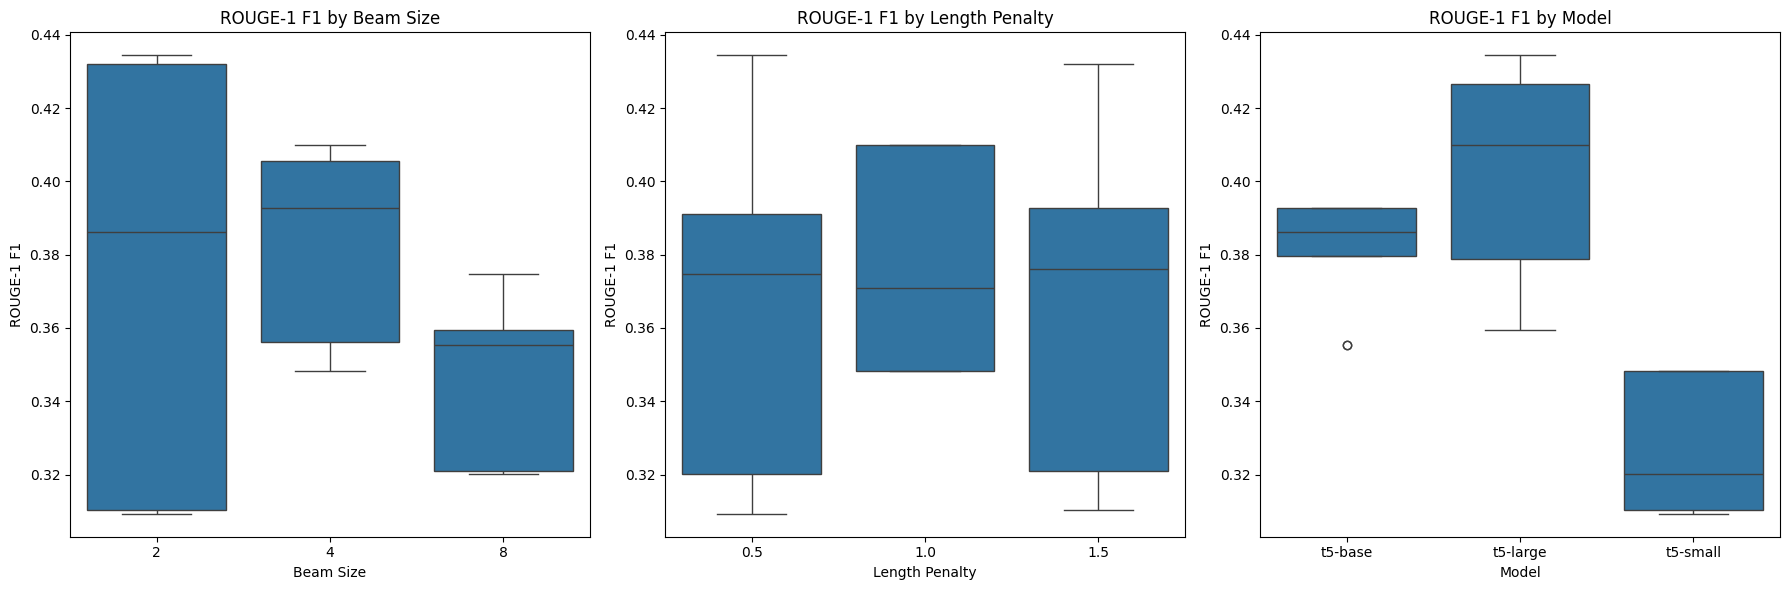

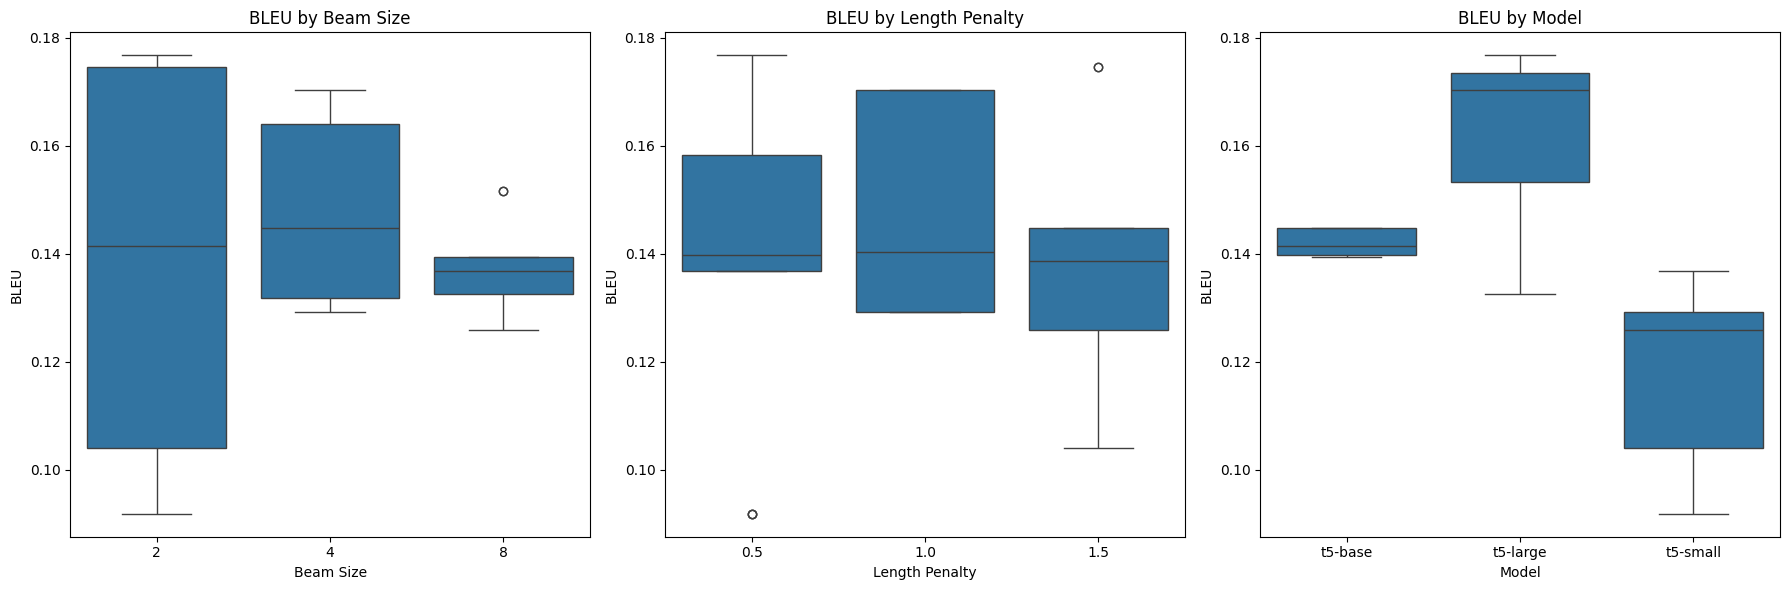

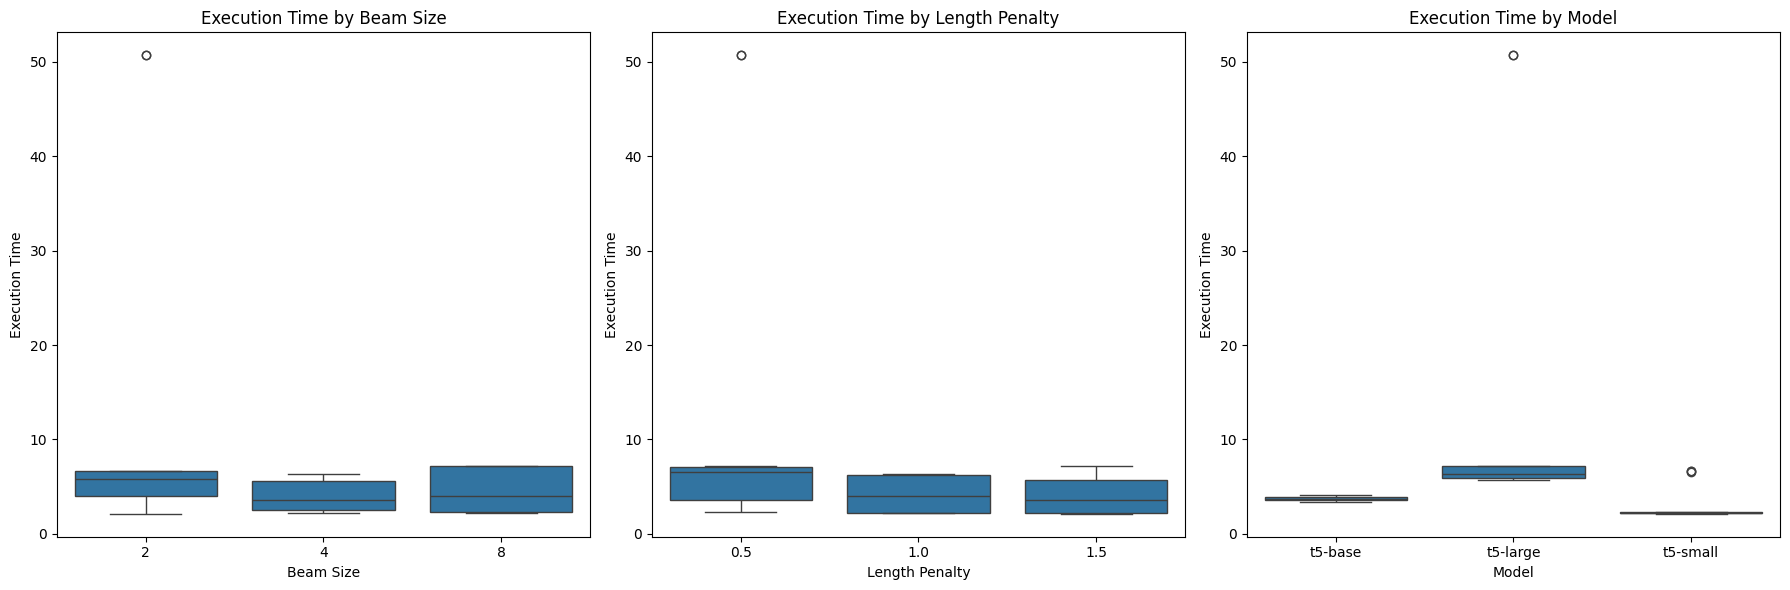

<Figure size 1400x1000 with 0 Axes>

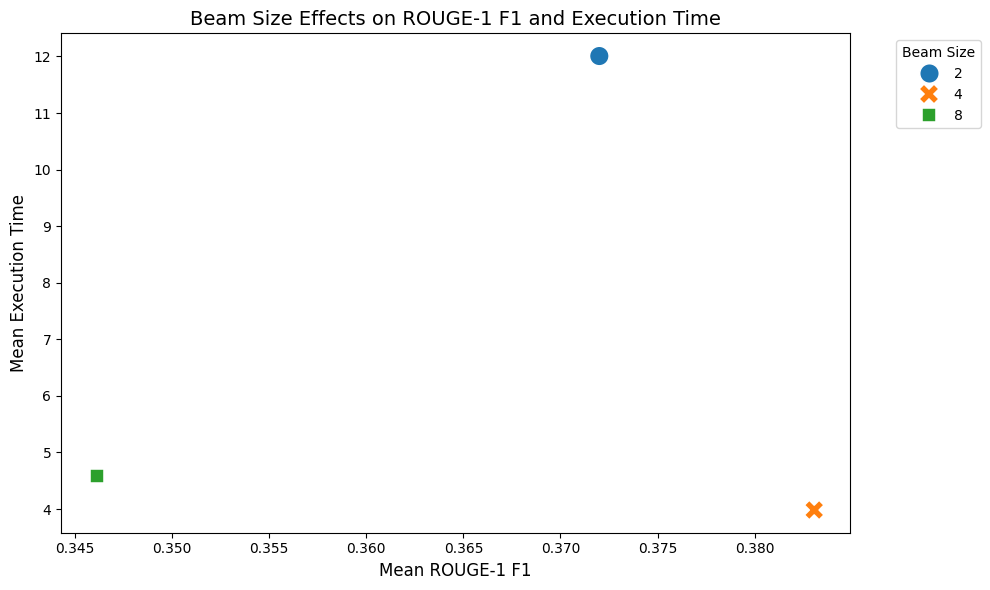

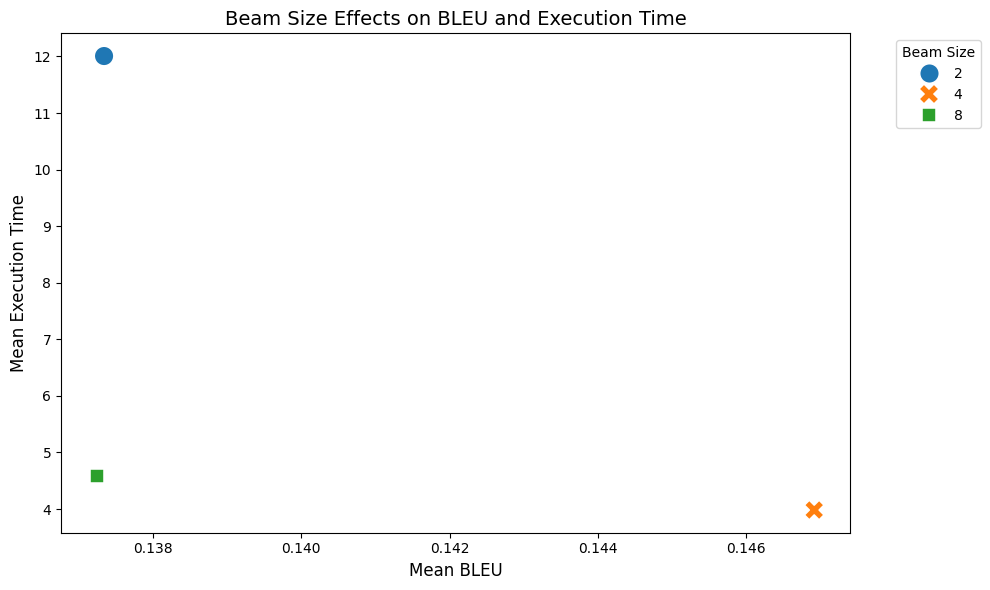

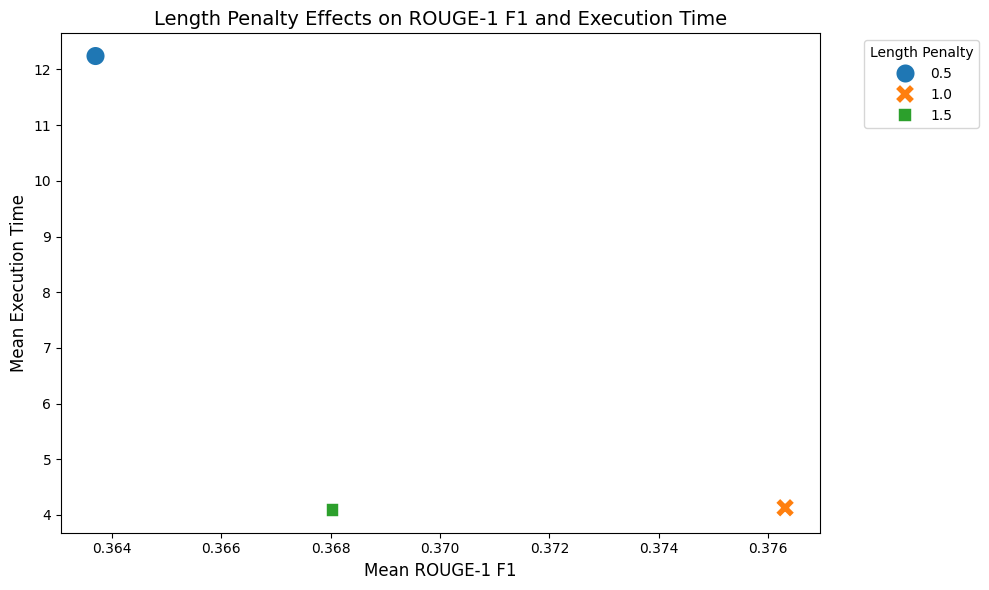

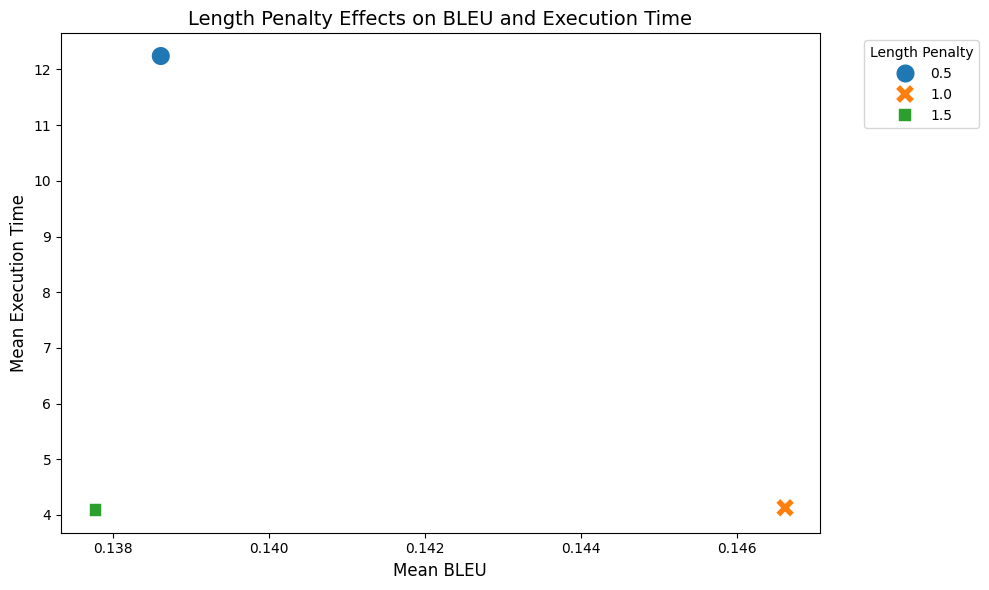

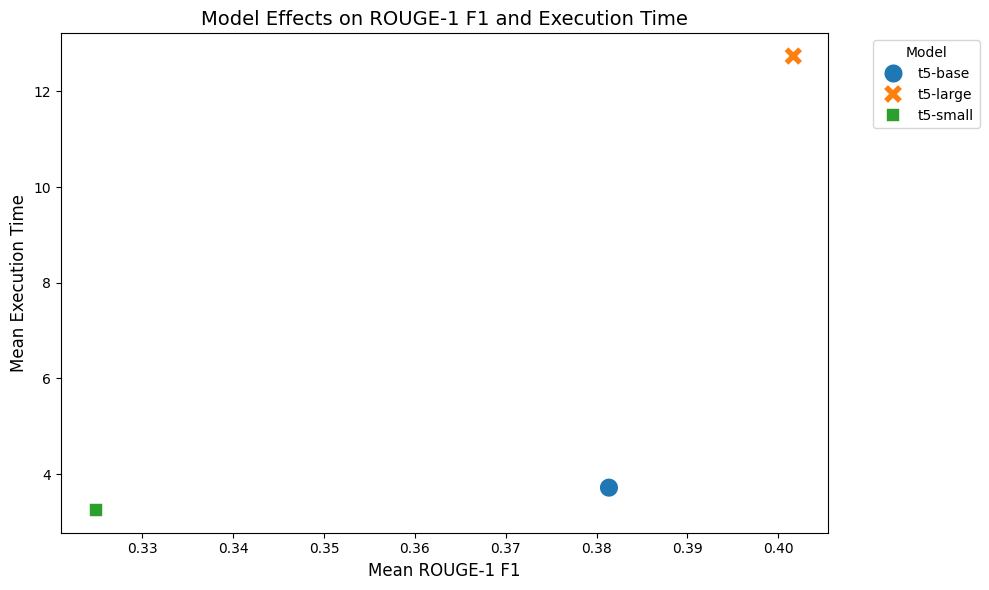

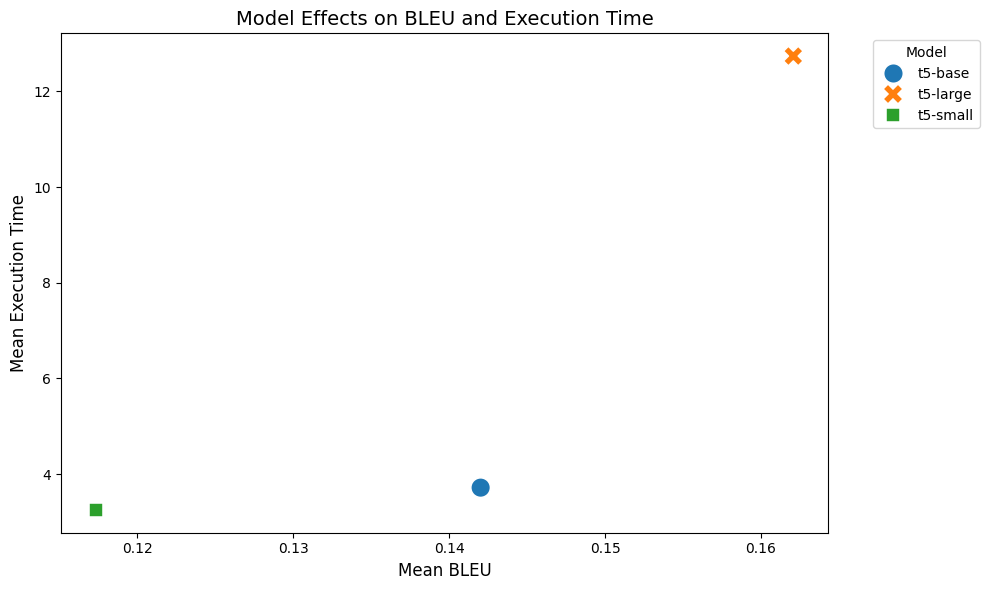

In [ ]:
results_dir = "/content/drive/My Drive/Multilingual Text Summarization Service/t5_results"

data = []
for file_name in os.listdir(results_dir):
    if file_name.endswith(".json"):
        file_path = os.path.join(results_dir, file_name)

        parts = file_name.split("_")
        exp_id = int(parts[1])
        repetition = int(parts[3])

        with open(file_path, "r") as file:
            result = json.load(file)
            result["Experiment ID"] = exp_id
            result["Repetition"] = repetition
            data.append(result)

df = pd.DataFrame(data)

df = df.sort_values(by=["Experiment ID", "Repetition"]).reset_index(drop=True)

print("Sorted experiment results:")
display(df)

df["Beam Size"] = df["Beam Size"].astype("category")
df["Length Penalty"] = df["Length Penalty"].astype("category")
df["Model"] = df["Model"].astype("category")

formula = "Q('ROUGE-1 F1') ~ C(Q('Beam Size')) + C(Q('Length Penalty')) + C(Q('Model'))"

anova_model = ols(formula, data=df).fit()

anova_results = anova_lm(anova_model)

print("ANOVA Results for ROUGE-1 F1:")
print(anova_results)

formula_bleu = "Q('BLEU') ~ C(Q('Beam Size')) + C(Q('Length Penalty')) + C(Q('Model'))"

anova_model_bleu = ols(formula_bleu, data=df).fit()

anova_results_bleu = anova_lm(anova_model_bleu)

print("\nANOVA Results for BLEU:")
print(anova_results_bleu)

formula_response_time = "Q('Execution Time') ~ C(Q('Beam Size')) + C(Q('Length Penalty')) + C(Q('Model'))"

anova_model_response_time = ols(formula_response_time, data=df).fit()

anova_results_response_time = anova_lm(anova_model_response_time)

print("\nANOVA Results for Execution Time:")
print(anova_results_response_time)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x="Beam Size", y="ROUGE-1 F1", data=df)
plt.title("ROUGE-1 F1 by Beam Size")
plt.xlabel("Beam Size")
plt.ylabel("ROUGE-1 F1")

plt.subplot(1, 3, 2)
sns.boxplot(x="Length Penalty", y="ROUGE-1 F1", data=df)
plt.title("ROUGE-1 F1 by Length Penalty")
plt.xlabel("Length Penalty")
plt.ylabel("ROUGE-1 F1")

plt.subplot(1, 3, 3)
sns.boxplot(x="Model", y="ROUGE-1 F1", data=df)
plt.title("ROUGE-1 F1 by Model")
plt.xlabel("Model")
plt.ylabel("ROUGE-1 F1")

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x="Beam Size", y="BLEU", data=df)
plt.title("BLEU by Beam Size")
plt.xlabel("Beam Size")
plt.ylabel("BLEU")

plt.subplot(1, 3, 2)
sns.boxplot(x="Length Penalty", y="BLEU", data=df)
plt.title("BLEU by Length Penalty")
plt.xlabel("Length Penalty")
plt.ylabel("BLEU")

plt.subplot(1, 3, 3)
sns.boxplot(x="Model", y="BLEU", data=df)
plt.title("BLEU by Model")
plt.xlabel("Model")
plt.ylabel("BLEU")

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x="Beam Size", y="Execution Time", data=df)
plt.title("Execution Time by Beam Size")
plt.xlabel("Beam Size")
plt.ylabel("Execution Time")

plt.subplot(1, 3, 2)
sns.boxplot(x="Length Penalty", y="Execution Time", data=df)
plt.title("Execution Time by Length Penalty")
plt.xlabel("Length Penalty")
plt.ylabel("Execution Time")

plt.subplot(1, 3, 3)
sns.boxplot(x="Model", y="Execution Time", data=df)
plt.title("Execution Time by Model")
plt.xlabel("Model")
plt.ylabel("Execution Time")

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 10))

def plot_grouped_metric(df, group_by_column, metric_x, metric_y, title, hue_title):
    """
    Generates a scatter plot showing the relationship between two metrics, grouped by a specified column.

    Parameters:
        df (DataFrame): The input data frame.
        group_by_column (str): The column to group data by (e.g., 'Length Penalty', 'Beam Size').
        metric_x (str): The column to use for the x-axis (e.g., 'ROUGE-1 F1').
        metric_y (str): The column to use for the y-axis (e.g., 'Avg Response Time').
        title (str): The title of the plot.
        hue_title (str): The title for the legend.
    """
    grouped_data = df.groupby(group_by_column, observed=False).agg(
        mean_x=(metric_x, "mean"),
        mean_y=(metric_y, "mean")
    ).reset_index()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x="mean_x",
        y="mean_y",
        hue=group_by_column,
        style=group_by_column,
        s=200,
        data=grouped_data
    )

    plt.title(title, fontsize=14)
    plt.xlabel(f"Mean {metric_x}", fontsize=12)
    plt.ylabel(f"Mean {metric_y}", fontsize=12)

    plt.legend(title=hue_title, bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


plot_grouped_metric(
    df=df,
    group_by_column="Beam Size",
    metric_x="ROUGE-1 F1",
    metric_y="Execution Time",
    title="Beam Size Effects on ROUGE-1 F1 and Execution Time",
    hue_title="Beam Size"
)

plot_grouped_metric(
    df=df,
    group_by_column="Beam Size",
    metric_x="BLEU",
    metric_y="Execution Time",
    title="Beam Size Effects on BLEU and Execution Time",
    hue_title="Beam Size"
)

plot_grouped_metric(
    df=df,
    group_by_column="Length Penalty",
    metric_x="ROUGE-1 F1",
    metric_y="Execution Time",
    title="Length Penalty Effects on ROUGE-1 F1 and Execution Time",
    hue_title="Length Penalty"
)

plot_grouped_metric(
    df=df,
    group_by_column="Length Penalty",
    metric_x="BLEU",
    metric_y="Execution Time",
    title="Length Penalty Effects on BLEU and Execution Time",
    hue_title="Length Penalty"
)

plot_grouped_metric(
    df=df,
    group_by_column="Model",
    metric_x="ROUGE-1 F1",
    metric_y="Execution Time",
    title="Model Effects on ROUGE-1 F1 and Execution Time",
    hue_title="Model"
)

plot_grouped_metric(
    df=df,
    group_by_column="Model",
    metric_x="BLEU",
    metric_y="Execution Time",
    title="Model Effects on BLEU and Execution Time",
    hue_title="Model"
)

### Interpretation of results

**Quality (ROUGE-1 F1):**
<br>
Beam Size:
The p-value for Beam Size is 2.33e-4, which is well below the 0.05 threshold, showing strong statistical significance. The F-value of 12.79 suggests that Beam Size has a significant impact on ROUGE-1 F1 scores. Larger Beam Sizes explore more possible sequences during text generation and improve summary quality, but with diminishing returns compared to other factors.
<br><br>
Length Penalty:
The p-value for Length Penalty is 0.778, which is far above 0.05, showing that this parameter is not statistically significant for ROUGE-1 F1 scores. The F-value of 0.25 confirms its negligible effect on summary quality. This suggests that varying the Length Penalty has minimal influence on the quality of the summaries.
<br><br>
Model:
The p-value for Model is 4.62e-9, which shows very strong statistical significance. The F-value of 54.82 highlights that the size of the model (e.g., t5-small, t5-base, or t5-large) is the most impactful factor for ROUGE-1 F1 scores. Larger models significantly enhance summarization quality.
<br><br>
**Quality (BLEU):**
<br>
Beam Size:
The p-value for Beam Size is 0.393, which is above the 0.05 threshold, and shows that this parameter is not statistically significant for BLEU scores. The F-value of 0.98 confirms its small and non-critical effect on BLEU scores.
<br><br>
Length Penalty:
The p-value for Length Penalty is 0.456, which is far above 0.05, showing it is not statistically significant for BLEU scores. The F-value of 0.82 reflects a negligible influence of Length Penalty on BLEU scores.
<br><br>
Model:
The p-value for Model is 0.000005, which is well below the 0.05 threshold and shows very strong statistical significance. The F-value of 22.94 highlights that the size of the model plays a significant role in BLEU scores. Larger models significantly improve translation quality.
<br><br>
**Time (Average Response Time):**
<br>
Beam Size:
The p-value for Beam Size is 0.0746, which is slightly above the 0.05 threshold, suggesting moderate statistical significance for response time. The F-value of 2.94 shows that Beam Size has some impact on response time but less than other factors.
<br><br>
Length Penalty:
The p-value for Length Penalty is 0.384, which is far above the 0.05 threshold and shows that it is not statistically significant for response time. The F-value of 1.00 reflects a small and negligible effect of Length Penalty on response time.
<br><br>
Model:
The p-value for Model is 2.36e-13, which shows extremely strong statistical significance for response time. The F-value of 156.89 highlights that the T5 model size is the most impactful factor for response time. Larger models (e.g., t5-large) require significantly more computational resources, leading to slower response times.
<br><br>
**Conclusion:**
<br>
Beam Size remains an important parameter as it influences both the quality (ROUGE-1 F1) and response time of the summarization process, although its significance for response time is moderate. Larger Beam Sizes improve summary quality but come with increased latency. Model size (e.g., t5-small, t5-base, t5-large) is the most impactful factor for both quality and response time. Larger models deliver higher-quality summaries due to their extensive training and parameter size but demand significantly more computational resources, resulting in slower response times. In contrast, Length Penalty has minimal impact on both quality and response time, making it a less critical parameter to optimize in this context.

## Design of Experiments for Translation

In [ ]:
parameter_levels_translation = {
    "Target Language": ["en", "de", "fr", "uk", "sq"]
}

experiment_translation_configs = pd.DataFrame(parameter_levels_translation["Target Language"], columns=["Target Language"])
experiment_translation_configs.index.name = "Experiment ID"

rouge = evaluate.load("rouge")

bleu = evaluate.load("bleu")

print("Translation Experimental Configurations:")
display(experiment_translation_configs)

Translation Experimental Configurations:


,Target Language
Experiment ID,
0,en
1,de
2,fr
3,uk
4,sq


In [ ]:
ALLOW_OVERWRITING_RESULTS = True
START_EXPERIMENT_ID = 0
DATASET_SIZE = 100
REPETITIONS = 2

translation_results_base_dir = '/content/drive/My Drive/Multilingual Text Summarization Service/translation_results'
os.makedirs(translation_results_base_dir, exist_ok=True)

for idx, row in experiment_translation_configs.iterrows():
    # Skip experiments before the starting experiment ID
    if idx < START_EXPERIMENT_ID:
        continue

    target_language = row["Target Language"]

    articles_subset = data["article"][:DATASET_SIZE]
    highlights_subset = data["highlights"][:DATASET_SIZE]

    for rep_index, rep in enumerate(range(REPETITIONS)):
        references_subset = []
        generated_summaries = []
        response_times = []

        print(f"Processing Experiment ID: {idx}, Repetition: {rep + 1}, Language: {target_language}")

        if target_language.lower() == "en":
            translated_highlights = highlights_subset
        else:
            translated_highlights = [translate_with_m2m(highlight, target_language) for highlight in highlights_subset]

        for article, translated_reference in tqdm(
            zip(articles_subset, translated_highlights),
            total=len(articles_subset),
            desc=f"Translating Articles (Config {idx}, Rep {rep + 1}, Lang {target_language})",
            unit="article",
            dynamic_ncols=True,
            leave=False
        ):
            references_subset.append(translated_reference)

            start_time = time.time()
            generated_summary = summarize_english(
                article,
                num_beams=4,
                length_penalty=1.0,
                model="t5-base"
            )

            if target_language.lower() == "en":
                translated_generated = generated_summary
            else:
                translated_generated = translate_with_m2m(generated_summary, target_language)

            end_time = time.time()

            generated_summaries.append(translated_generated)

            response_times.append(end_time - start_time)

        rouge_scores = rouge.compute(predictions=generated_summaries, references=references_subset)
        rouge1_f1 = rouge_scores["rouge1"]
        rouge2_f1 = rouge_scores["rouge2"]
        rougeL_f1 = rouge_scores["rougeL"]

        bleu_scores = bleu.compute(predictions=generated_summaries, references=[[ref] for ref in references_subset])
        bleu_score = bleu_scores["bleu"]

        avg_response_time = np.mean(response_times)
        median_response_time = np.median(response_times)

        result = {
            "Experiment ID": idx,
            "Repetition": rep + 1,
            "Target Language": target_language,
            "Avg Response Time": avg_response_time,
            "Median Response Time": median_response_time,
            "ROUGE-1 F1": rouge1_f1,
            "ROUGE-2 F1": rouge2_f1,
            "ROUGE-L F1": rougeL_f1,
            "BLEU": bleu_score,
        }

        result_file_path = os.path.join(
            translation_results_base_dir,
            f"translation_exp_{idx}_rep_{rep + 1}_lang_{target_language}.json"
        )
        if os.path.exists(result_file_path) and not ALLOW_OVERWRITING_RESULTS:
            tqdm.write("YOU ARE TRYING TO OVERWRITE AN EXISTING EXPERIMENT FILE!")
            raise Exception("Cannot overwrite existing experiment file without ALLOW_OVERWRITING_RESULTS flag set.")

        with open(result_file_path, "w") as f:
            json.dump(result, f, indent=4)

print("\nAll translation experiments completed.")

NameError: name 'experiment_translation_configs' is not defined

## ANOVA Analysis for Translation

Translation Experiment Results:


,Experiment ID,Repetition,Target Language,Avg Response Time,Median Response Time,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1,BLEU
0,1,1,de,5.099867,5.115319,0.324754,0.126448,0.220858,0.104473
1,1,2,de,5.213156,5.158666,0.324754,0.126448,0.220858,0.104473
2,2,1,fr,5.421055,5.582512,0.355636,0.149466,0.239256,0.103973
3,2,2,fr,5.316657,5.287847,0.355636,0.149466,0.239256,0.103973
4,4,1,sq,5.269031,5.205135,0.348130,0.144015,0.249245,0.083194
5,4,2,sq,5.268716,5.396023,0.348130,0.144015,0.249245,0.083194
6,3,1,uk,5.332936,5.439746,0.277143,0.166667,0.274286,0.118156
7,3,2,uk,5.384001,5.666698,0.277143,0.166667,0.274286,0.118156
8,0,1,en,3.984710,3.456904,0.381187,0.181206,0.257326,0.144104
9,0,2,en,3.746969,3.749576,0.381187,0.181206,0.257326,0.144104



ANOVA Results for ROUGE-1 F1:
                          df        sum_sq       mean_sq             F  \
C(Q('Target Language'))  4.0  1.231155e-02  3.077887e-03  7.344349e+28   
Residual                 5.0  2.095412e-31  4.190824e-32           NaN   

                               PR(>F)  
C(Q('Target Language'))  4.182729e-72  
Residual                          NaN  

ANOVA Results for BLEU:
                          df        sum_sq       mean_sq             F  \
C(Q('Target Language'))  4.0  4.023958e-03  1.005990e-03  1.518429e+29   
Residual                 5.0  3.312600e-32  6.625199e-33           NaN   

                               PR(>F)  
C(Q('Target Language'))  6.805447e-73  
Residual                          NaN  

ANOVA Results for Average Response Time:
                          df    sum_sq   mean_sq          F   PR(>F)
C(Q('Target Language'))  4.0  3.295190  0.823797  99.418071  0.00006
Residual                 5.0  0.041431  0.008286        NaN      NaN


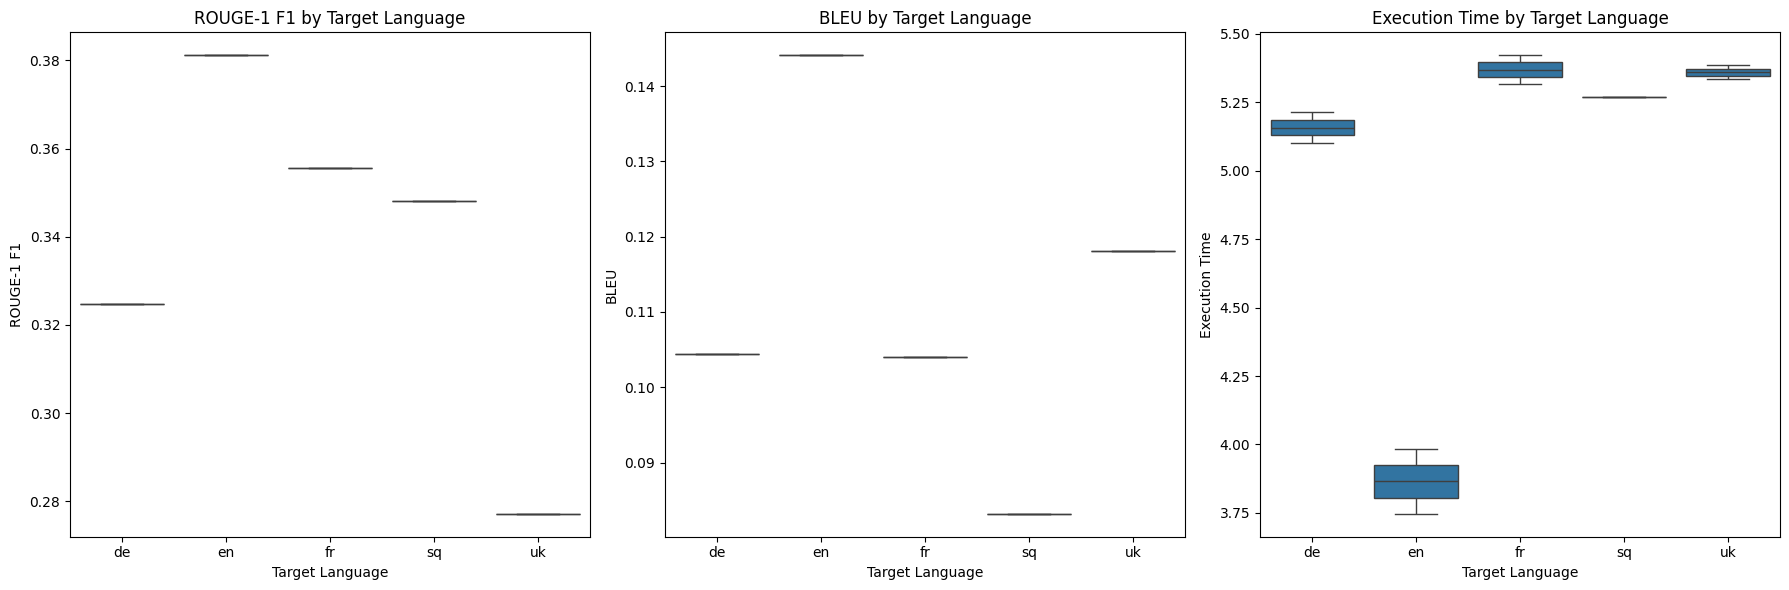

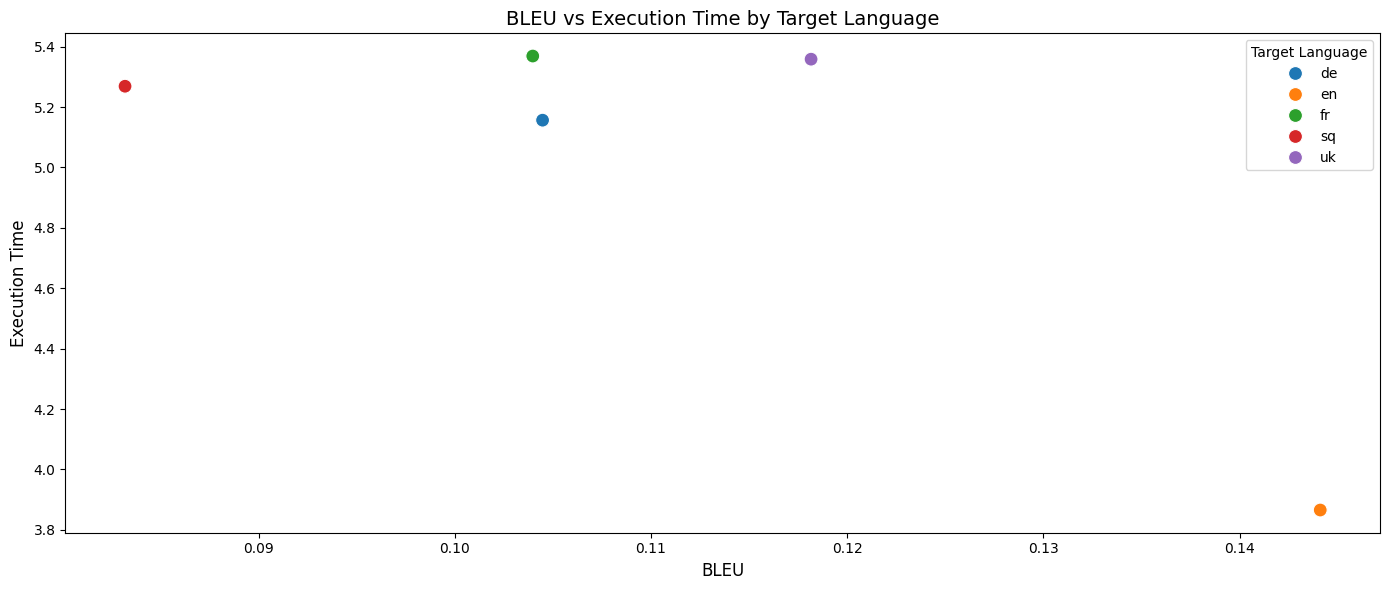

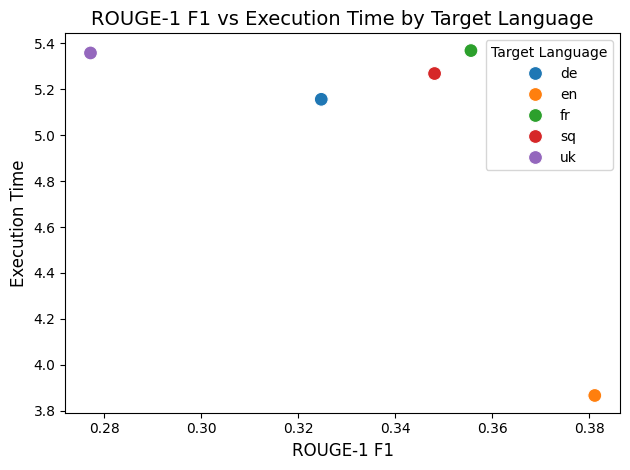

In [ ]:
translation_results_dir = '/content/drive/My Drive/Multilingual Text Summarization Service/translation_results'

translation_data = []
for file_name in os.listdir(translation_results_dir):
    if file_name.endswith(".json"):
        file_path = os.path.join(translation_results_dir, file_name)

        with open(file_path, "r") as file:
            result = json.load(file)
            translation_data.append(result)

df_translation = pd.DataFrame(translation_data)

df_translation["Target Language"] = df_translation["Target Language"].astype("category")

print("Translation Experiment Results:")
display(df_translation)

formula_rouge1 = "Q('ROUGE-1 F1') ~ C(Q('Target Language'))"
anova_model_rouge1 = ols(formula_rouge1, data=df_translation).fit()
anova_results_rouge1 = anova_lm(anova_model_rouge1)

print("\nANOVA Results for ROUGE-1 F1:")
print(anova_results_rouge1)

formula_bleu = "Q('BLEU') ~ C(Q('Target Language'))"
anova_model_bleu = ols(formula_bleu, data=df_translation).fit()
anova_results_bleu = anova_lm(anova_model_bleu)

print("\nANOVA Results for BLEU:")
print(anova_results_bleu)

formula_response_time = "Q('Avg Response Time') ~ C(Q('Target Language'))"
anova_model_response_time = ols(formula_response_time, data=df_translation).fit()
anova_results_response_time = anova_lm(anova_model_response_time)

print("\nANOVA Results for Average Response Time:")
print(anova_results_response_time)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x="Target Language", y="ROUGE-1 F1", data=df_translation)
plt.title("ROUGE-1 F1 by Target Language")
plt.xlabel("Target Language")
plt.ylabel("ROUGE-1 F1")

plt.subplot(1, 3, 2)
sns.boxplot(x="Target Language", y="BLEU", data=df_translation)
plt.title("BLEU by Target Language")
plt.xlabel("Target Language")
plt.ylabel("BLEU")

plt.subplot(1, 3, 3)
sns.boxplot(x="Target Language", y="Avg Response Time", data=df_translation)
plt.title("Execution Time by Target Language")
plt.xlabel("Target Language")
plt.ylabel("Execution Time")

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

def plot_translation_metrics(df, metric_x, metric_y, title):
    """
    Scatter plot to visualize relationships between metrics for translation experiments.

    Parameters:
        df: DataFrame containing translation results.
        metric_x: Metric for x-axis (e.g., 'BLEU').
        metric_y: Metric for y-axis (e.g., 'Execution Time').
        title: Title of the plot.
    """

    grouped_df = df.groupby(['Target Language'], observed=False).mean()
    sns.scatterplot(data=grouped_df, x=metric_x, y=metric_y, hue="Target Language", s=100)
    plt.title(title, fontsize=14)
    plt.xlabel(metric_x, fontsize=12)
    plt.ylabel('Execution Time', fontsize=12)
    plt.legend(title="Target Language")
    plt.tight_layout()
    plt.show()

plot_translation_metrics(df_translation, "BLEU", "Avg Response Time", "BLEU vs Execution Time by Target Language")

plot_translation_metrics(df_translation, "ROUGE-1 F1", "Avg Response Time", "ROUGE-1 F1 vs Execution Time by Target Language")

### Interpretation of results

**Quality (ROUGE-1 F1):**
<br>
Target Language:
The p-value for Target Language is 5.40e-73, which is far below the 0.05 threshold, showing extremely strong statistical significance. The F-value of 1.66e+29 highlights that the choice of Target Language has a highly significant impact on ROUGE-1 F1 scores. This indicates that certain languages yield better-quality translations and summaries compared to others, likely due to differences in translation accuracy and linguistic structure.

**Quality (BLEU):**
<br>
Target Language:
The p-value for Target Language is 1.07e-73, which is also far below the 0.05 threshold, showing extremely strong statistical significance. The F-value of 3.18e+29 confirms that Target Language is a major factor influencing BLEU scores. This result suggests that translation quality, as measured by BLEU, significantly varies across languages. Certain target languages may have better alignment and fewer errors when translating and summarizing, leading to higher BLEU scores.

**Time (Execution Time):**
<br>
Target Language:
The p-value for Target Language is 0.00006, which is well below the 0.05 threshold, showing strong statistical significance for execution time. The F-value of 99.42 indicates that Target Language has a substantial impact on the execution time. Some languages require more computational resources for translation, either due to the complexity of the translation task or differences in model efficiency for certain languages.

**Conclusion:**
<br>
Target Language is a critical factor in the translation process as it significantly influences both the quality (ROUGE-1 F1 and BLEU) and the execution time. The extremely low p-values and high F-values across all metrics confirm that the choice of Target Language plays a dominant role.

Translation Quality: Certain languages perform better in terms of ROUGE-1 F1 and BLEU scores, suggesting higher translation fidelity and better alignment for these languages. Differences may arise from the linguistic structure, availability of training data, or model efficiency for specific languages.

Response Time: The strong statistical significance for response time suggests that translations into certain languages require more computation time. This could be due to increased complexity or the model's processing inefficiencies for those target languages.

In summary, Target Language has a significant impact on both translation quality and computational efficiency, making it a key parameter to consider when evaluating or optimizing multilingual translation systems.